In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy 
import matplotlib.pyplot as plt
import sys 
import pdb
import pandas as pd
from pyuoi.linear_model.var import VAR
from sklearn.model_selection import KFold
from tqdm import tqdm

In [3]:
sys.path.append('/home/akumar/nse/neural_control')

In [4]:
from loaders import load_sabes, load_peanut, load_cv
from segmentation import reach_segment_sabes
from utils import form_companion, calc_loadings, apply_df_filters
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from dca.cov_util import form_lag_matrix

In [5]:
dat = load_sabes('/mnt/Secondary/data/sabes/indy_20160627_01.mat')

In [7]:
X = dat['spike_rates'].squeeze()

In [25]:
form_lag_matrix(xtest, 3).shape

(13450, 519)

In [28]:
form_companion(varmodel.coef_).shape

(519, 519)

In [ ]:
varmodel.coef_.shape

(3, 173, 173)

In [29]:
# Question 1: Affect of self regression on the spectrum and predictive capacity
Asr = []
r2sr = []

A = []
r2 = []

for train_idxs, test_idxs in tqdm(KFold(n_splits=5).split(X)):

    xtrain = X[train_idxs]
    xtest = X[test_idxs]

    #xtrain = scipy.ndimage.gaussian_filter1d(X[train_idxs], axis=0, sigma=1)
    #xtest = scipy.ndimage.gaussian_filter1d(X[test_idxs], axis=0, sigma=1)

    # varmodel = VAR(estimator='ols', self_regress=True, order=3)
    # varmodel.fit(X[train_idxs])    form_lag_matrix

    # Asr.append(varmodel.coef_.squeeze())
    # r2sr.append(varmodel.score(X[test_idxs]))
    
    varmodel = VAR(estimator='ols', self_regress=False, order=3)
    varmodel.fit(xtrain)
    
    r2.append(r2_score(xtest[2:], form_lag_matrix(xtest, 3) @ form_companion(varmodel.coef_)))


    break
    # A.append(varmodel.coef_.squeeze())
    # r2.append(varmodel.score(xtest))
    # break

0it [00:00, ?it/s]/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), VAR_OLS_Wrapper())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous b

ValueError: y_true and y_pred have different number of output (173!=519)

In [31]:
r2_score(xtest[2:], (form_lag_matrix(xtest, 3) @ form_companion(varmodel.coef_))[:, 0:173])

-3.339676901702794

In [14]:
# Nonlinear least squares 

[0.02944863548635064,
 0.03676642160075907,
 0.04171878633622061,
 0.04111464384334377,
 0.02789409213024925]

In [18]:
r2

[1665009.3504453748]

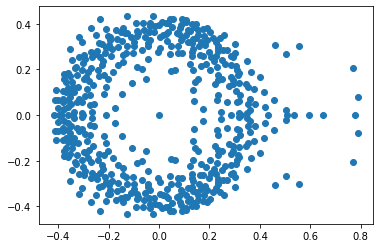

In [61]:
plt.scatter(np.real(np.linalg.eigvals(form_companion(A[0]))), np.imag(np.linalg.eigvals(form_companion(A[0]))))

In [8]:
# Filter by low error reaches
dat = reach_segment_sabes(dat, data_file='indy_20160627_01', err_thresh=0.5)

Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


In [16]:
# Truncate at 15 to allow for an even array
X = np.array([dat['spike_rates'].squeeze()[t[0]:t[1]][0:15] for t in dat['transition_times']])

In [17]:
# Question 1: Affect of self regression on the spectrum and predictive capacity
Asret = []
r2sret = []

Aet = []
r2et = []

for train_idxs, test_idxs in tqdm(KFold(n_splits=5).split(X)):
    varmodel = VAR(estimator='ols', self_regress=True, order=1)
    varmodel.fit(X[train_idxs])
    Asret.append(varmodel.coef_.squeeze())
    r2sret.append(varmodel.score(X[test_idxs]))
    
    varmodel = VAR(estimator='ols', self_regress=False, order=1)
    varmodel.fit(X[train_idxs])
    Aet.append(varmodel.coef_.squeeze())
    r2et.append(varmodel.score(X[test_idxs]))


0it [00:00, ?it/s]/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), VAR_OLS_Wrapper())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



In [6]:
X = dat['spike_rates'].squeeze()
xsmooth = scipy.ndimage.gaussian_filter1d(X, sigma=1, axis=0)

In [7]:
# Question 1: Affect of self regression on the spectrum and predictive capacity

A_smooth = []
r2_smooth = []

A_smooth_diff = []
r2_smooth_diff = []


for train_idxs, test_idxs in tqdm(KFold(n_splits=5).split(xsmooth)):
    xtrain = xsmooth[train_idxs]
    xtest = xsmooth[test_idxs]

    xtrain = StandardScaler().fit_transform(xtrain)
    xtest = StandardScaler().fit_transform(xtest)

    linmodel = LinearRegression().fit(xtrain[:-1, :], xtrain[1:, :])
    # print(r2_score(xtest[1:, :], xtest[:-1, :] @ linmodel.coef_))

    A_smooth.append(linmodel.coef_)

    xdiff_train = StandardScaler().fit_transform(np.diff(xtrain, axis=0))
    xdiff_test = StandardScaler().fit_transform(np.diff(xtest, axis=0))

    linmodel = LinearRegression().fit(xtrain[:-1, :], xdiff_train)
    print(r2_score(xdiff_test, xtest[:-1, :] @ linmodel.coef_))

    A_smooth_diff.append(linmodel.coef_)



0it [00:00, ?it/s]

1it [00:00,  1.18it/s]

0.0024021214134244797


2it [00:01,  1.21it/s]

-0.004399098884923534


3it [00:02,  1.17it/s]

-0.0066798249772100264


4it [00:03,  1.16it/s]

-0.006416199430567237


5it [00:04,  1.17it/s]

-0.0030448483647009046


In [8]:
A_smooth[2] - A_smooth_diff[2]

array([[ 1.12205048e+00, -3.09515212e-03,  3.71119702e-03, ...,
        -1.22861733e-02, -2.97891190e-03, -4.19371579e-03],
       [ 2.35360314e-03,  1.12876008e+00, -8.95620780e-03, ...,
        -2.30782310e-04,  3.15592344e-03,  1.91714300e-03],
       [-1.25809160e-03,  1.61374892e-03,  1.13215187e+00, ...,
        -2.61017145e-03,  1.27182207e-02, -7.10810798e-03],
       ...,
       [ 1.52598114e-03, -2.92072745e-03,  3.26900087e-03, ...,
         1.13050402e+00,  3.68059894e-03, -1.23215433e-02],
       [-1.31002909e-02,  1.97962217e-03,  7.82368436e-04, ...,
        -1.41829031e-02,  1.17986657e+00, -7.72750752e-03],
       [-2.44925126e-03,  2.65531703e-03,  2.99486262e-03, ...,
        -1.69815149e-03,  7.19682721e-04,  1.19746298e+00]])

In [5]:
from pseudopy.nonnormal import NonnormalAuto
from pseudopy.normal import Normal


In [10]:
nn1 = NonnormalAuto(A_smooth_diff[0], 1e-3, 1)
n1 = Normal(A_smooth_diff[0])

In [6]:
import pickle

In [7]:
# with open('M1_LDSfit.pkl', 'wb') as f:
#     f.write(pickle.dumps(nn1))
#     f.write(pickle.dumps(n1))
#     f.write(pickle.dumps(A_smooth_diff[0]))   
with open('M1_LDSfit.pkl', 'rb') as f:
    nn1 = pickle.load(f)
    n1 = pickle.load(f)
    A_smooth_diff = [pickle.load(f)]

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/pseudopy/normal.py:38: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  pseudospec = cascaded_union(circles)
/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/pseudopy/utils.py:40: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in obj:


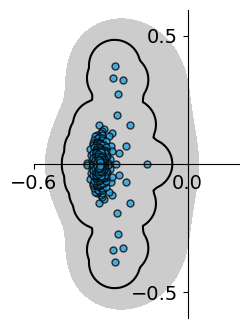

In [8]:
fig, ax = plt.subplots(figsize=(4, 4))
nnobj = nn1
nobj = n1
A_ = A_smooth_diff[0]

levels = [1e-6, 1.2e-1]

ax.set_aspect('equal')
ax.tricontourf(nnobj.triang, nnobj.vals, levels=levels, colors=['k'], alpha=0.2)

ax.scatter(np.real(np.linalg.eigvals(A_)), np.imag(np.linalg.eigvals(A_)), s=25, alpha=0.75, marker='o', edgecolor='k', color='#1d9fe0')

epsilons = list(np.sort(levels))
padepsilons = [epsilons[0]*0.9] + epsilons + [epsilons[-1]*1.1]
X = []
Y = []
Z = []
for epsilon in padepsilons:
    paths = nobj.contour_paths(epsilon)
    for path in paths:
        X += list(np.real(path.vertices[:-1]))
        Y += list(np.imag(path.vertices[:-1]))
        Z += [epsilon] * (len(path.vertices) - 1)
ax.tricontour(X, Y, Z, levels=[1e-1], colors='k')


# Add stability circle
# circle1 = plt.Circle((0, 0), 1, color='k', fill=False, linestyle='--')
# ax.add_patch(circle1)
# ax.set_ylabel('Im' + r'$(z)$', fontsize=14)
# ax.set_yticks([-1., -0.5, 0, 0.5, 1.])
# ax.set_xlabel('Re' + r'$(z)$', fontsize=14)
# ax.set_xticks([-1., -0.5, 0, 0.5, 1.])

ax.set_xlim([-0.6, 0.2])
ax.set_ylim([-0.6, 0.6])
#ax.xaxis.tick_top()
#ax.xaxis.set_label_position('top')
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticks([-0.6, 0])
ax.set_yticks([-0.5, 0.5])

ax.tick_params(axis='both', labelsize=14)
fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/M1_pseudo_cont_narrow.pdf', bbox_inches='tight', pad_inches=0)

In [15]:
dat = load_sabes('/mnt/Secondary/data/sabes/indy_20160426_01.mat')

In [16]:
X = dat['spike_rates'].squeeze()
xsmooth = scipy.ndimage.gaussian_filter1d(X, sigma=1, axis=0)

In [17]:
# Question 1: Affect of self regression on the spectrum and predictive capacity

A_smooth = []
r2_smooth = []

A_smooth_diff = []
r2_smooth_diff = []


for train_idxs, test_idxs in tqdm(KFold(n_splits=5).split(xsmooth)):
    xtrain = xsmooth[train_idxs]
    xtest = xsmooth[test_idxs]

    xtrain = StandardScaler().fit_transform(xtrain)
    xtest = StandardScaler().fit_transform(xtest)

    linmodel = LinearRegression().fit(xtrain[:-1, :], xtrain[1:, :])
    # print(r2_score(xtest[1:, :], xtest[:-1, :] @ linmodel.coef_))

    A_smooth.append(linmodel.coef_)

    xdiff_train = StandardScaler().fit_transform(np.diff(xtrain, axis=0))
    xdiff_test = StandardScaler().fit_transform(np.diff(xtest, axis=0))

    linmodel = LinearRegression().fit(xtrain[:-1, :], xdiff_train)
    print(r2_score(xdiff_test, xtest[:-1, :] @ linmodel.coef_))

    A_smooth_diff.append(linmodel.coef_)



0it [00:00, ?it/s]

1it [00:00,  2.12it/s]

-0.022718343827795886


2it [00:00,  2.02it/s]

-0.02868764339131857


3it [00:01,  1.98it/s]

-0.03218451705399785


4it [00:02,  1.96it/s]

-0.0358391042413987


5it [00:02,  1.97it/s]

-0.024607603160960802


In [18]:
nn1 = NonnormalAuto(A_smooth_diff[0], 1e-5, 1)
n1 = Normal(A_smooth_diff[0])

In [9]:
# with open('S1_LDSfit.pkl', 'wb') as f:
#     f.write(pickle.dumps(nn1))
#     f.write(pickle.dumps(n1))
#     f.write(pickle.dumps(A_smooth_diff[0]))   
with open('S1_LDSfit.pkl', 'rb') as f:
    nn1 = pickle.load(f)
    n1 = pickle.load(f)
    A_smooth_diff = [pickle.load(f)]

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/pseudopy/normal.py:38: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  pseudospec = cascaded_union(circles)
/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/pseudopy/utils.py:40: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in obj:


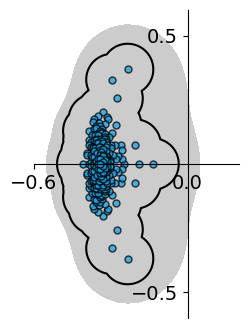

In [10]:
# S1
fig, ax = plt.subplots(figsize=(4, 4))
nnobj = nn1
nobj = n1
A_ = A_smooth_diff[0]

levels = [1e-6, 1e-1]

ax.set_aspect('equal')
ax.tricontourf(nnobj.triang, nnobj.vals, levels=levels, colors=['k'], alpha=0.2)

ax.scatter(np.real(np.linalg.eigvals(A_)), np.imag(np.linalg.eigvals(A_)), s=25, alpha=0.75, marker='o', edgecolor='k', color='#1d9fe0')

epsilons = list(np.sort(levels))
padepsilons = [epsilons[0]*0.9] + epsilons + [epsilons[-1]*1.1]
X = []
Y = []
Z = []
for epsilon in padepsilons:
    paths = nobj.contour_paths(epsilon)
    for path in paths:
        X += list(np.real(path.vertices[:-1]))
        Y += list(np.imag(path.vertices[:-1]))
        Z += [epsilon] * (len(path.vertices) - 1)
ax.tricontour(X, Y, Z, levels=[1e-1], colors='k')


# Add stability circle
# circle1 = plt.Circle((0, 0), 1, color='k', fill=False, linestyle='--')
# ax.add_patch(circle1)
# ax.set_ylabel('Im' + r'$(z)$', fontsize=14)
# ax.set_yticks([-1., -0.5, 0, 0.5, 1.])
# ax.set_xlabel('Re' + r'$(z)$', fontsize=14)
# ax.set_xticks([-1., -0.5, 0, 0.5, 1.])

ax.set_xlim([-0.6, 0.2])
ax.set_ylim([-0.6, 0.6])
#ax.xaxis.tick_top()
#ax.xaxis.set_label_position('top')
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticks([-0.6, 0])
ax.set_yticks([-0.5, 0.5])

ax.tick_params(axis='both', labelsize=14)
fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/S1_pseudo_cont_narrow.pdf', bbox_inches='tight', pad_inches=0)

In [52]:
dat = load_sabes('/mnt/Secondary/data/sabes/indy_20160426_01.mat', region='S1')

96


In [53]:
X = dat['spike_rates'].squeeze()
xsmooth = scipy.ndimage.gaussian_filter1d(X, sigma=1, axis=0)

In [54]:
# Question 1: Affect of self regression on the spectrum and predictive capacity

A_smooth = []
r2_smooth = []

A_smooth_diff = []
r2_smooth_diff = []


for train_idxs, test_idxs in tqdm(KFold(n_splits=5).split(xsmooth)):
    xtrain = xsmooth[train_idxs]
    xtest = xsmooth[test_idxs]

    xtrain = StandardScaler().fit_transform(xtrain)
    xtest = StandardScaler().fit_transform(xtest)

    linmodel = LinearRegression().fit(xtrain[:-1, :], xtrain[1:, :])
    # print(r2_score(xtest[1:, :], xtest[:-1, :] @ linmodel.coef_))

    A_smooth.append(linmodel.coef_)

    xdiff_train = StandardScaler().fit_transform(np.diff(xtrain, axis=0))
    xdiff_test = StandardScaler().fit_transform(np.diff(xtest, axis=0))

    linmodel = LinearRegression().fit(xtrain[:-1, :], xdiff_train)
    print(r2_score(xdiff_test, xtest[:-1, :] @ linmodel.coef_))

    A_smooth_diff.append(linmodel.coef_)



0it [00:00, ?it/s]

1it [00:00,  3.90it/s]

0.044548564635532806


2it [00:00,  4.34it/s]

0.04114412510208116


3it [00:00,  4.26it/s]

0.042377424371806985


4it [00:00,  4.38it/s]

0.03914721258514672


5it [00:01,  4.34it/s]

0.054448436714506825


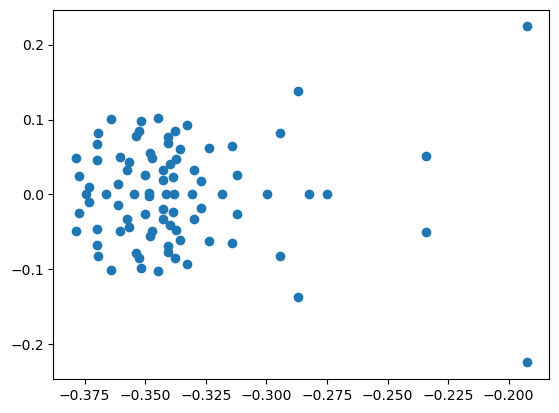

In [55]:
plt.scatter(np.real(np.linalg.eigvals(A_smooth_diff[0])), np.imag(np.linalg.eigvals(A_smooth_diff[0])))

In [11]:
nn1 = NonnormalAuto(A_smooth_diff[0], 1e-5, 1)
n1 = Normal(A_smooth_diff[0])

In [115]:
# Do the same thing for peanut, CV
loader_args = {'bin_width':50, 'epoch': 4, 'filter_fn':'none', 'filter_kwargs':{}, 'boxcox':0.5, 'spike_threshold':100}
dat = load_peanut('/mnt/Secondary/data/peanut/data_dict_peanut_day14.obj', **loader_args, region='HPc')
X = np.squeeze(dat['spike_rates'])
xsmooth = scipy.ndimage.gaussian_filter1d(X, sigma=1, axis=0)

xtrain = StandardScaler().fit_transform(xsmooth)
xdiff_train = StandardScaler().fit_transform(np.diff(xsmooth, axis=0))
linmodel = LinearRegression().fit(xtrain[:-1, :], xdiff_train)
A_peanut = linmodel.coef_

In [116]:
nnp = NonnormalAuto(A_peanut, 1e-5, 1)
normp = Normal(A_peanut)

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/pseudopy/nonnormal.py:321: RuntimeWarning: divide by zero encountered in double_scalars
  if numpy.abs(radius)/numpy.abs(midpoint) > 1e-15:


/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/pseudopy/normal.py:38: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  pseudospec = cascaded_union(circles)
/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/pseudopy/utils.py:40: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in obj:


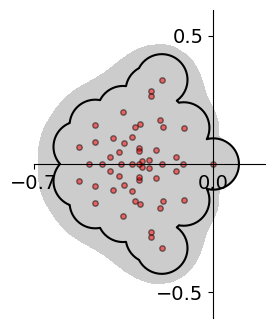

In [118]:
fig, ax = plt.subplots(figsize=(4, 4))
nnobj = nnp
nobj = normp
A_ = A_peanut

levels = [1e-6, 1e-1]

ax.set_aspect('equal')
ax.tricontourf(nnobj.triang, nnobj.vals, levels=levels, colors=['k'], alpha=0.2)

ax.scatter(np.real(np.linalg.eigvals(A_)), np.imag(np.linalg.eigvals(A_)), s=15, alpha=0.5, marker='o', edgecolor='k', color='r')

epsilons = list(np.sort(levels))
padepsilons = [epsilons[0]*0.9] + epsilons + [epsilons[-1]*1.1]
X = []
Y = []
Z = []
for epsilon in padepsilons:
    paths = nobj.contour_paths(epsilon)
    for path in paths:
        X += list(np.real(path.vertices[:-1]))
        Y += list(np.imag(path.vertices[:-1]))
        Z += [epsilon] * (len(path.vertices) - 1)
ax.tricontour(X, Y, Z, levels=[1e-1], colors='k')


# Add stability circle
# circle1 = plt.Circle((0, 0), 1, color='k', fill=False, linestyle='--')
# ax.add_patch(circle1)
# ax.set_ylabel('Im' + r'$(z)$', fontsize=14)
# ax.set_yticks([-1., -0.5, 0, 0.5, 1.])
# ax.set_xlabel('Re' + r'$(z)$', fontsize=14)
# ax.set_xticks([-1., -0.5, 0, 0.5, 1.])

ax.set_xlim([-0.6, 0.2])
ax.set_ylim([-0.6, 0.6])
#ax.xaxis.tick_top()
#ax.xaxis.set_label_position('top')
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticks([-0.7, 0])
ax.set_yticks([-0.5, 0.5])

ax.tick_params(axis='both', labelsize=14)
fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/peanut_pseudo_cont_narrow.pdf', bbox_inches='tight', pad_inches=0)

In [5]:
# Do the same thing for peanut, CV
#loader_args = {'bin_width':50, 'epoch': 4, 'filter_fn':'none', 'filter_kwargs':{}, 'boxcox':0.5, 'spike_threshold':100}
dat = load_cv('/mnt/Secondary/data/cv/EC2_hg.h5')
X = np.squeeze(dat['spike_rates'])
#xsmooth = scipy.ndimage.gaussian_filter1d(X, sigma=1, axis=0)
xsmooth = np.reshape(X, (-1, X.shape[-1]))
xsmooth = scipy.ndimage.gaussian_filter1d(xsmooth, sigma=1, axis=0)

xtrain = StandardScaler().fit_transform(xsmooth)
xdiff_train = StandardScaler().fit_transform(np.diff(xsmooth, axis=0))
linmodel = LinearRegression().fit(xtrain[:-1, :], xdiff_train)
A_cv = linmodel.coef_

In [8]:
nnp = NonnormalAuto(A_cv, 1e-5, 1)
normp = Normal(A_cv)

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/pseudopy/normal.py:38: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  pseudospec = cascaded_union(circles)
/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/pseudopy/utils.py:40: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in obj:


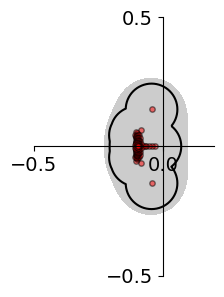

In [9]:
fig, ax = plt.subplots(figsize=(2.333, 4))
nnobj = nnp
nobj = normp
A_ = A_cv

levels = [1e-6, 1e-1]

ax.set_aspect('equal')
ax.tricontourf(nnobj.triang, nnobj.vals, levels=levels, colors=['k'], alpha=0.2)

ax.scatter(np.real(np.linalg.eigvals(A_)), np.imag(np.linalg.eigvals(A_)), s=15, alpha=0.5, marker='o', edgecolor='k', color='r')

epsilons = list(np.sort(levels))
padepsilons = [epsilons[0]*0.9] + epsilons + [epsilons[-1]*1.1]
X = []
Y = []
Z = []
for epsilon in padepsilons:
    paths = nobj.contour_paths(epsilon)
    for path in paths:
        X += list(np.real(path.vertices[:-1]))
        Y += list(np.imag(path.vertices[:-1]))
        Z += [epsilon] * (len(path.vertices) - 1)
ax.tricontour(X, Y, Z, levels=[1e-1], colors='k')


# Add stability circle
# circle1 = plt.Circle((0, 0), 1, color='k', fill=False, linestyle='--')
# ax.add_patch(circle1)
# ax.set_ylabel('Im' + r'$(z)$', fontsize=14)
# ax.set_yticks([-1., -0.5, 0, 0.5, 1.])
# ax.set_xlabel('Re' + r'$(z)$', fontsize=14)
# ax.set_xticks([-1., -0.5, 0, 0.5, 1.])

ax.set_xlim([-0.5, 0.2])
ax.set_ylim([-0.35, 0.35])
#ax.xaxis.tick_top()
#ax.xaxis.set_label_position('top')
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticks([-0.5, 0])
ax.set_yticks([-0.5, 0.5])

ax.tick_params(axis='both', labelsize=14)
fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/cv_pseudo_cont.pdf', bbox_inches='tight', pad_inches=0)

In [34]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler

In [38]:
# Regression on first differences
A_diff = []
r2_diff = []

for train_idxs, test_idxs in tqdm(KFold(n_splits=5).split(X)):

    xtrain = StandardScaler().fit_transform(X[train_idxs])
    xtest = StandardScaler().fit_transform(X[test_idxs])
    linmodel = LinearRegression()

    linmodel.fit(xtrain[:-1, :], np.diff(xtrain, axis=0))
    r2 = linmodel.score(xtest[:-1, :], np.diff(xtest, axis=0))

    A_diff.append(linmodel.coef_)
    r2_diff.append(r2)

5it [00:03,  1.51it/s]


In [40]:
r2_diff

[0.463592308777434,
 0.4679500589074835,
 0.4626768399710865,
 0.46458185703834576,
 0.46047579576317366]

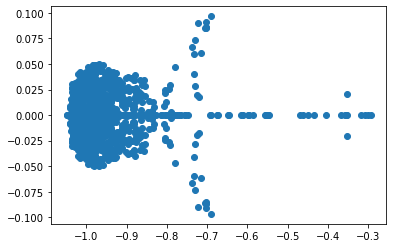

In [41]:
plt.scatter(np.real(np.linalg.eigvals(A_diff)), np.imag(np.linalg.eigvals(A_diff)))

In [42]:
from dca.cov_util import form_lag_matrix

In [56]:
# Try a higher order model with smoothing
Asr = []
r2sr = []

A = []
r2 = []

for train_idxs, test_idxs in tqdm(KFold(n_splits=5).split(X)):

    xtrain = StandardScaler().fit_transform(X[train_idxs])
    xtest = StandardScaler().fit_transform(X[test_idxs])

    #xtrain = scipy.ndimage.gaussian_filter1d(xtrain, axis=0, sigma=1)
    #xtest = scipy.ndimage.gaussian_filter1d(xtest, axis=0, sigma=1)

    # Don't allow self regression
    

    linmodel = LinearRegression()
    linmodel.fit(form_lag_matrix(xtrain, 3), xtrain[2:])
    r2_= linmodel.score(form_lag_matrix(xtest, 3), xtest[2:])
    print(r2_)

    A.append(linmodel.coef_.reshape((xtrain.shape[1], xtrain.shape[1], -1)))


1it [00:03,  3.71s/it]

0.9942196531791907


2it [00:07,  3.49s/it]

1.0


3it [00:10,  3.41s/it]

0.9942196531791907


4it [00:15,  4.00s/it]

1.0


5it [00:18,  3.72s/it]

1.0


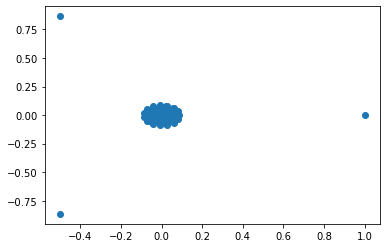

In [57]:
plt.scatter(np.real(np.linalg.eigvals(form_companion(A[0].transpose((2, 0,1))))), np.imag(np.linalg.eigvals(form_companion(A[0].transpose((2, 0, 1))))))

In [6]:
# Autoregression and regression onto the first numerical differences should be directly equivalent to each other. Why does this not seem to be the case?
from neurosim.models.ssr import StateSpaceRealization as SSR, gen_random_model

In [7]:
A, B, C = gen_random_model(20)

In [8]:
ssr = SSR(A, B, C)
x = ssr.trajectory(int(1e3))

In [14]:
x = StandardScaler().fit_transform(x)

In [28]:
linmodel = LinearRegression()
linmodel.fit(x[:-1], x[1:])
M1 = linmodel.coef_

In [20]:
(np.linalg.inv(x[:-1].T @ x[:-1]) @ x[:-1].T @ x[1:]).T

array([[ 1.00885598e-01,  2.18434001e-01, -1.75847119e-01,
        -2.06109326e-01,  1.23748004e-01,  4.75733521e-02,
        -1.09257692e-01, -7.02884475e-02,  1.17570069e-01,
        -3.17867077e-02, -1.11473303e-01,  1.39593982e-01,
        -2.23200491e-01, -1.32832322e-02, -7.89559331e-02,
        -1.38219529e-02,  1.15604886e-01, -1.04467259e-01,
        -3.28934501e-01, -2.67859159e-02],
       [ 9.58674310e-03,  1.29274810e-01,  9.76757095e-02,
         2.73408478e-01, -6.62121562e-03, -8.76820608e-03,
        -5.43197624e-02, -3.25438178e-01, -1.80848162e-01,
        -4.29283161e-02, -2.14050971e-02, -2.25494700e-02,
        -5.65187216e-02, -5.55564120e-02,  3.08975609e-02,
        -1.16365002e-02,  9.45521735e-02,  7.68254217e-02,
         1.13230856e-01,  2.40475874e-01],
       [-5.62210458e-02, -5.69318840e-02, -1.24677308e-01,
         2.14684723e-01, -1.68148747e-02, -4.10524495e-01,
         6.30433677e-03, -1.87478603e-01,  9.86910847e-02,
        -1.22612778e-01, -1.3

In [17]:
linmodel.coef_

array([[ 1.00885284e-01,  2.18434756e-01, -1.75846597e-01,
        -2.06108655e-01,  1.23748332e-01,  4.75728358e-02,
        -1.09259129e-01, -7.02883464e-02,  1.17569988e-01,
        -3.17872541e-02, -1.11473931e-01,  1.39594210e-01,
        -2.23201040e-01, -1.32841632e-02, -7.89561445e-02,
        -1.38212618e-02,  1.15605072e-01, -1.04467561e-01,
        -3.28934814e-01, -2.67859262e-02],
       [ 9.58592904e-03,  1.29276768e-01,  9.76770633e-02,
         2.73410218e-01, -6.62036306e-03, -8.76954512e-03,
        -5.43234871e-02, -3.25437916e-01, -1.80848373e-01,
        -4.29297330e-02, -2.14067270e-02, -2.25488782e-02,
        -5.65201477e-02, -5.55588266e-02,  3.08970125e-02,
        -1.16347080e-02,  9.45526552e-02,  7.68246378e-02,
         1.13230045e-01,  2.40475848e-01],
       [-5.62214984e-02, -5.69307953e-02, -1.24676555e-01,
         2.14685690e-01, -1.68144007e-02, -4.10525239e-01,
         6.30226594e-03, -1.87478457e-01,  9.86909674e-02,
        -1.22613566e-01, -1.3

In [25]:
linmodel = LinearRegression()
linmodel.fit(x[:-1], np.diff(x, axis=0))
M2 = linmodel.coef_

In [22]:
linmodel.coef_

array([[-8.99114716e-01,  2.18434756e-01, -1.75846597e-01,
        -2.06108655e-01,  1.23748332e-01,  4.75728358e-02,
        -1.09259129e-01, -7.02883464e-02,  1.17569988e-01,
        -3.17872541e-02, -1.11473931e-01,  1.39594210e-01,
        -2.23201040e-01, -1.32841632e-02, -7.89561445e-02,
        -1.38212618e-02,  1.15605072e-01, -1.04467561e-01,
        -3.28934814e-01, -2.67859262e-02],
       [ 9.58592904e-03, -8.70723232e-01,  9.76770633e-02,
         2.73410218e-01, -6.62036306e-03, -8.76954512e-03,
        -5.43234871e-02, -3.25437916e-01, -1.80848373e-01,
        -4.29297330e-02, -2.14067270e-02, -2.25488782e-02,
        -5.65201477e-02, -5.55588266e-02,  3.08970125e-02,
        -1.16347080e-02,  9.45526552e-02,  7.68246378e-02,
         1.13230045e-01,  2.40475848e-01],
       [-5.62214984e-02, -5.69307953e-02, -1.12467656e+00,
         2.14685690e-01, -1.68144007e-02, -4.10525239e-01,
         6.30226594e-03, -1.87478457e-01,  9.86909674e-02,
        -1.22613566e-01, -1.3

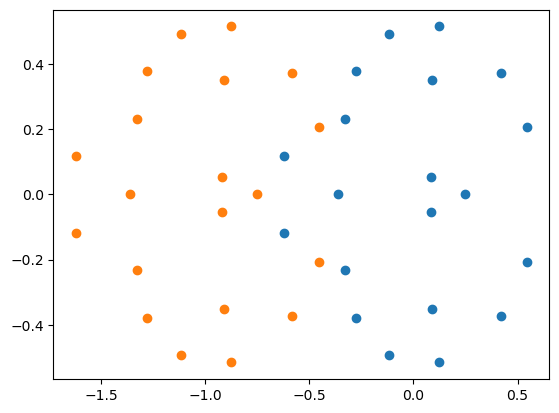

In [32]:
plt.scatter(np.real(np.linalg.eigvals(M1)), np.imag(np.linalg.eigvals(M1)))
plt.scatter(np.real(np.linalg.eigvals(M2)), np.imag(np.linalg.eigvals(M2)))

In [33]:
# The curious case of regression onto numerical differences:


In [ ]:
# Other alternatives
# (1) Regress on 1st differences
# Smooth
# (2) Use low rank input
# (3) Use nonlinear least squares with an RNN model, and then look at the Jacobian

### Correspondence between model derived and second order statistics defined loadings

In [33]:
import pickle

In [36]:
with open('/mnt/Secondary/data/postprocessed/sabes_var_df.dat', 'rb') as f:
    var_df = pickle.load(f)

In [51]:
with open('/mnt/Secondary/data/postprocessed/indy_decoding_df2.dat', 'rb') as f:
    indy_df = pickle.load(f)

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [63]:
indy_df = pd.DataFrame(indy_df)

In [52]:
from neurosim.models.ssr import StateSpaceRealization as SSR
from dca_research.lqg import LQGComponentsAnalysis as LQGCA

In [57]:
np.unique(var_df['fold_idx'].values)

array([0, 1, 2, 3, 4])

In [65]:
np.unique(indy_df['dimreduc_method'].values)

array(['DCA', 'KCA', 'LQGCA', 'PCA'], dtype=object)

In [71]:
df2 = apply_df_filters(indy_df, fold_idx=var_df.iloc[i]['fold_idx'], data_file=var_df.iloc[i]['data_file'], dimreduc_method='LQGCA', decoder_args={'trainlag': 4, 'testlag': 4, 'decoding_window': 5})

In [80]:
spr = np.zeros((var_df.shape[0], 10))

for i in tqdm(range(var_df.shape[0])):

    df2 = apply_df_filters(indy_df, fold_idx=var_df.iloc[i]['fold_idx'], data_file=var_df.iloc[i]['data_file'], dimreduc_method='LQGCA', dim=2)
    assert(df2.shape[0] == 1)

    A = var_df.iloc[i]['A']
    ssr = SSR(A=A, B=np.eye(A.shape[0]), C=np.eye(A.shape[0]))
    
    ccm = ssr.autocorrelation(10)
    lqgmodel = LQGCA(T=1, d=6)

    ccm_rev_norm = np.array([np.linalg.inv(ccm[0]) @ c.T @ np.linalg.inv(ccm[0]) for c in ccm])

    lqgmodel.cross_covs = torch.tensor(ccm)
    lqgmodel.cross_covs_rev = torch.tensor(ccm_rev_norm)

    loadings_ref = calc_loadings(df2.iloc[0]['coef'])

    for j in range(10):        
        V, _ = lqgmodel._fit_projection()
        loadings_ = calc_loadings(V)
        spr[i, j] = scipy.stats.spearmanr(loadings_ref, loadings_)[0]

100%|██████████| 140/140 [02:36<00:00,  1.12s/it]


In [81]:
spr

array([[0.46101537, 0.44299963, 0.47789726, ..., 0.45313236, 0.43557255,
        0.45649194],
       [0.49168354, 0.47852718, 0.47532958, ..., 0.48235471, 0.48039295,
        0.47065617],
       [0.48517435, 0.52370154, 0.49182152, ..., 0.54755456, 0.53071466,
        0.48611624],
       ...,
       [0.44336113, 0.42994178, 0.42148859, ..., 0.43403934, 0.47335956,
        0.42276633],
       [0.51959087, 0.51753265, 0.51227695, ..., 0.51555625, 0.52214634,
        0.52261212],
       [0.49904642, 0.47710464, 0.48768529, ..., 0.45968214, 0.49042329,
        0.47796066]])